In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
# 读取数据
train = pd.read_csv('/root/autodl-fs/data/train_revise+45缩减到100特征 数量1000个 去掉三列和Name.csv')

# 分离特征和标签
X = train.drop(['senolytic'], axis=1)
y = train['senolytic']

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# 定义XGBoost模型和参数网格
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# 使用GridSearchCV进行超参数调优
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# 获取最佳参数
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# 获取最佳模型
best_xgb = grid_search.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8;, score=0.801 total time= 9.2min
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.8;, score=0.850 total time=15.1min
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1.0;, score=0.824 total time=16.0min
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8;, score=0.824 total time= 9.3min
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=1.0;, score=0.850 total time=14.8min
[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8;, score=0.850 total time=16.4min
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0;, score=0.838 total time= 8.8min
[CV 1/3] END co

In [4]:
# 在测试集上进行预测
y_pred = best_xgb.predict(X_test)
y_pred_proba = best_xgb.predict_proba(X_test)[:, 1]

# 计算评价指标
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# 计算PR曲线并计算PR AUC
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_vals, precision_vals)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("PR AUC Score:", pr_auc)

Accuracy: 0.875
Precision: 0.6428571428571429
Recall: 0.5454545454545454
F1 Score: 0.5901639344262296
ROC AUC Score: 0.8092905098893124
PR AUC Score: 0.6555508380611077


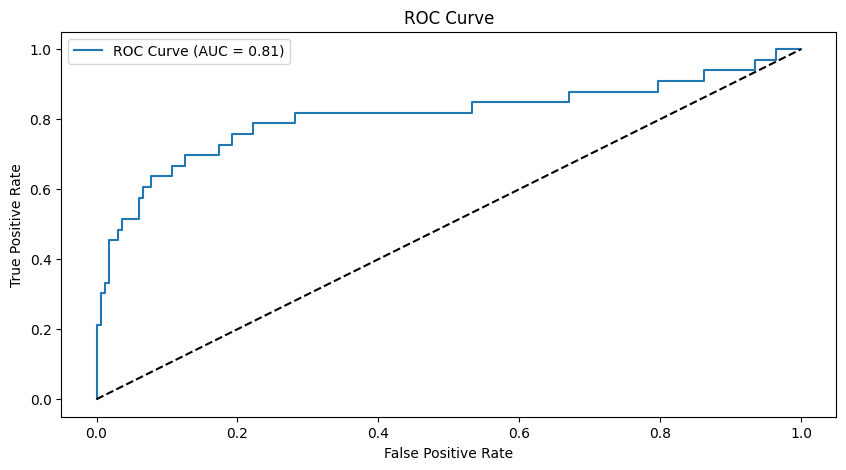

In [5]:
# 绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
# 绘制PR曲线
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_vals, precision_vals)
plt.figure(figsize=(10, 5))
plt.plot(recall_vals, precision_vals, label=f'XGBoost (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()